# <center> Deep Learning Project:

> - __Ahmed Abdelazeem__ (m20210433)
> - __Omar Jarir__ (m20201378)  
> - __Chung-Ting Huang__ (m20210437) 
> - __Pedro Moura Gomes__ (m20200322)

***

- __The objective of this notebook is to perform hyperparameters tuning:__
- Some references:
>   - https://neptune.ai/blog/keras-tuner-tuning-hyperparameters-deep-learning-model/amp
>   - https://keras.io/guides/keras_tuner/getting_started/
>   - https://keras.io/api/utils/serialization_utils/
>   - https://www.tensorflow.org/tutorials/keras/keras_tuner
>   - https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py

In [1]:
# !pip install keras-tuner --upgrade
# !pip install -q -U keras-tuner
#!pip install findspark
#!pip install tensorflow-addons

In [2]:
import time
t1 = time.perf_counter()

***

- __Importing the necessary libraries 📚:__

In [3]:
import numpy as np
import random as python_random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras 
import keras_tuner as kt
import keras.backend as K
import tensorflow_addons as tfa

In [4]:
from keras.models import Model, Sequential
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, History, ReduceLROnPlateau 
from keras import optimizers

from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif, VarianceThreshold 
from sklearn.utils import class_weight

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import scikitplot as skplt
from imblearn.over_sampling import SMOTE

import IPython

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
SEED = 2022

Fixing the random number seed to ensure that the results are reproducible.

In [7]:
session = K.get_session()

np.random.seed(SEED)
tf.random.set_seed(SEED)
python_random.seed(SEED)

- __Helper functions:__

In [8]:
# Function to create dataframe with metrics

def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
    measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
    train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain, average='macro'),
                metricsObj.f1_score(yTrain, yPredTrain, average='macro'),
                metricsObj.roc_auc_score(yTrain, yPredTrain),    
                ]
    test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest),
               metricsObj.recall_score(yTest, yPredTest, average='macro'),
               metricsObj.f1_score(yTest, yPredTest, average='macro'),
               metricsObj.roc_auc_score(yTest, yPredTest), 
               ]
    resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results}, index=measures_list)
    return resultsDF

In [9]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [10]:
def MutualInfoScores(X, y):    
    mi = pd.Series(mutual_info_classif(X, y))
    mi /= mi.max()
    mi.index = X.columns
    mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
    plt.title("Feature univariate score")
    plt.ylabel('Mutual Information')
    plt.show();
    return mi

In [11]:
def FTestScores(X, y):
    f_scores = pd.Series(-np.log10(f_classif(X, y)[1]))
    f_scores /= f_scores.max()
    f_scores.index = X.columns
    f_scores = f_scores.sort_values(ascending=False)
    f_scores.plot.bar(figsize=(20,6))
    plt.title("Feature univariate score")
    plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
    plt.show();
    return f_scores

In [12]:
def remove_correlated(X):
    corr = X.corr()
    i = 1
    for (index, row) in corr.iterrows():
        for col in corr.columns[i:]:
            if np.abs(row[col]) > 0.9:
                print(f"{index} vs. {col} are highly correlated {row[col]}")
        i += 1
        # Select upper triangle of correlation matrix
    corr_matrix = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    # Find features with correlation greater than 0.9
    correlated_cols = [c for c in corr_matrix.columns if any(np.abs(corr_matrix[c]) > 0.9)]
    # Drop correlated columns
    return correlated_cols

In [13]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [14]:
# This function plot the "loss" and the "val_loss" variables.
def visualize_loss(history, title):
    """
    history: history of the model.
    title: Title of the plot.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, "g", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show();

In [15]:
# This function plot the "accuracy" and the "val_accuracy" variables.
def visualize_accuracy(history, title):
    """
    history: history of the model.
    title: Title of the plot.
    """
    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, "g", label="Training accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation accuracy")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show();

In [16]:
# This function plot the "auc" and the "val_auc" variables.
def visualize_auc(history, title):
    """
    history: history of the model.
    title: Title of the plot.
    """
    loss = history.history["auc"]
    val_loss = history.history["val_auc"]
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, "g", label="Training AUC")
    plt.plot(epochs, val_loss, "b", label="Validation AUC")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("AUC")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show();

In [17]:
# This function plot the "precision" and the "val_precision" variables.
def visualize_precision(history, title):
    """
    history: history of the model.
    title: Title of the plot.
    """
    loss = history.history["precision"]
    val_loss = history.history["val_precision"]
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, "g", label="Training Precision")
    plt.plot(epochs, val_loss, "b", label="Validation Precision")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show();

In [18]:
# This function plot the "recall" and the "val_recall" variables.
def visualize_recall(history, title):
    """
    history: history of the model.
    title: Title of the plot.
    """
    loss = history.history["recall"]
    val_loss = history.history["val_recall"]
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, "g", label="Training Recall")
    plt.plot(epochs, val_loss, "b", label="Validation Recall")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show();

In [19]:
# This function plot the "f1" and the "val_f1" variables.
def visualize_f1(history, title):
    """
    history: history of the model.
    title: Title of the plot.
    """
    loss = history.history["f1"]
    val_loss = history.history["val_f1"]
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, "g", label="Training F1")
    plt.plot(epochs, val_loss, "b", label="Validation F1")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("F1-score")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show();

In [20]:
def auc_plot(y_test, y_pred_test_proba):
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_test_proba)
    auc_keras = auc(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC (area = {:.3f})'.format(auc_keras), color="g")
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show();

***

- __Loading and exploring the dataset:__

In [21]:
ds= pd.read_csv("data.csv")

In [22]:
ds.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [23]:
# Checking the shape of the dataset:

ds.shape

(6819, 96)

In [24]:
# We can see that our dataset does not contain any duplicates.

ds.duplicated().sum()

0

In [25]:
# Checking the type of the columns:

ds.dtypes

Bankrupt?                                                     int64
 ROA(C) before interest and depreciation before interest    float64
 ROA(A) before interest and % after tax                     float64
 ROA(B) before interest and depreciation after tax          float64
 Operating Gross Margin                                     float64
                                                             ...   
 Liability to Equity                                        float64
 Degree of Financial Leverage (DFL)                         float64
 Interest Coverage Ratio (Interest expense to EBIT)         float64
 Net Income Flag                                              int64
 Equity to Liability                                        float64
Length: 96, dtype: object

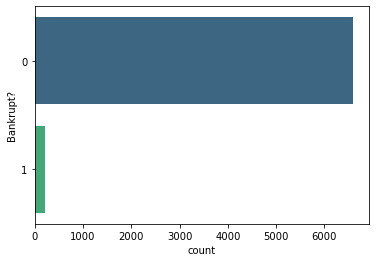

In [26]:
# Checking that the target distribution is imbalanced.

sns.countplot(y='Bankrupt?', data = ds, palette='viridis', orient = 'h');

In [27]:
ds["Bankrupt?"].value_counts(normalize=True)

0    0.967737
1    0.032263
Name: Bankrupt?, dtype: float64

__Splitting the dataset:__

In [28]:
X = ds.copy(deep=True)

In [29]:
y = X["Bankrupt?"]
X = X.drop(columns=["Bankrupt?"])

In [30]:
# Split the dataset intro train and test sets.

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.3,
                                   shuffle =True, stratify=y, random_state=SEED)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.3,
                                   shuffle = True, stratify=y_train, random_state=SEED)

__Dropping the correlated features:__

In [31]:
correlated_cols = remove_correlated(x_train)
x_train = x_train.drop(columns=correlated_cols)
x_val = x_val.drop(columns=correlated_cols)
x_test = x_test.drop(columns=correlated_cols)

 ROA(C) before interest and depreciation before interest vs.  ROA(A) before interest and % after tax are highly correlated 0.9446419463916639
 ROA(C) before interest and depreciation before interest vs.  ROA(B) before interest and depreciation after tax are highly correlated 0.9864245462264032
 ROA(A) before interest and % after tax vs.  ROA(B) before interest and depreciation after tax are highly correlated 0.9615395188598046
 ROA(A) before interest and % after tax vs.  Net Income to Total Assets are highly correlated 0.9552847017108241
 ROA(B) before interest and depreciation after tax vs.  Net Income to Total Assets are highly correlated 0.911624147935095
 Operating Gross Margin vs.  Realized Sales Gross Margin are highly correlated 0.9994220651059769
 Operating Gross Margin vs.  Gross Profit to Sales are highly correlated 0.9999999904240435
 Realized Sales Gross Margin vs.  Gross Profit to Sales are highly correlated 0.9994219264950949
 Pre-tax net Interest Rate vs.  After-tax net 

__Dealing with outliers:__

In [32]:
classifier = IsolationForest(n_estimators=100, random_state=SEED)

#identify outliers:
y_train_pred = classifier.fit_predict(x_train)
y_val_pred = classifier.predict(x_val)
y_test_pred = classifier.predict(x_test)

#Remove outliers where 1 represent inliers and -1 represent outliers:
x_train = x_train[np.where(y_train_pred == 1, True, False)]
x_val = x_val[np.where(y_val_pred == 1, True, False)]
x_test = x_test[np.where(y_test_pred == 1, True, False)]

y_train = y_train[np.where(y_train_pred == 1, True, False)]
y_val = y_val[np.where(y_val_pred == 1, True, False)]
y_test = y_test[np.where(y_test_pred == 1, True, False)]

In [33]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(3285, 76)
(2011, 76)
(1411, 76)


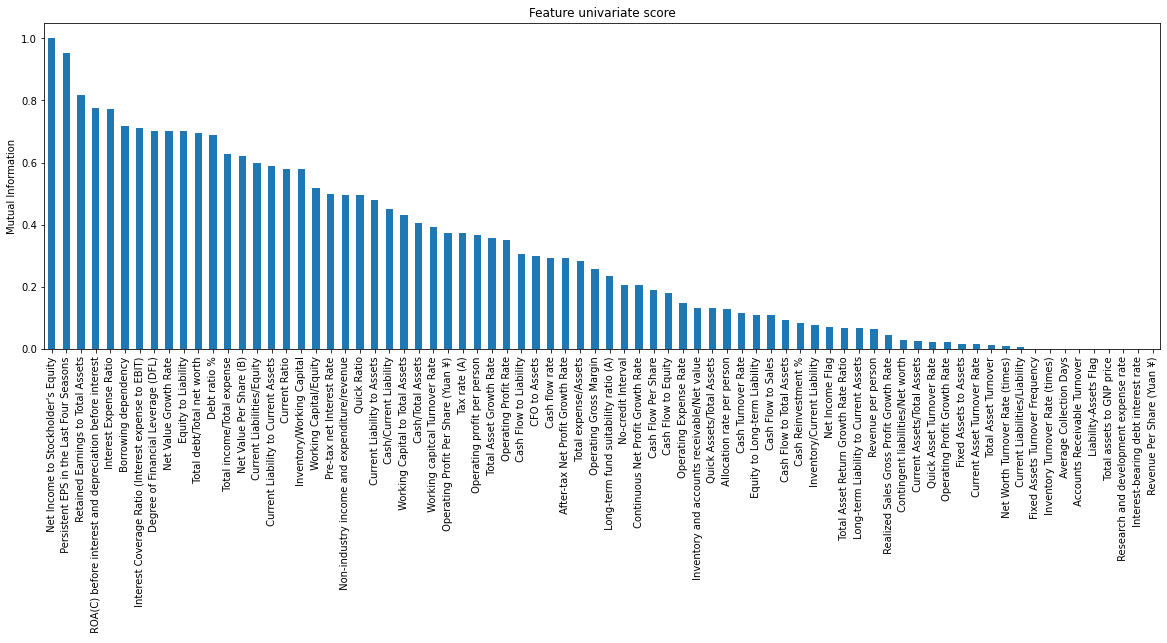

 ROA(C) before interest and depreciation before interest    0.775001
 Operating Gross Margin                                     0.256038
 Operating Profit Rate                                      0.349181
 Pre-tax net Interest Rate                                  0.497222
 Non-industry income and expenditure/revenue                0.496033
                                                              ...   
 Net Income to Stockholder's Equity                         1.000000
 Degree of Financial Leverage (DFL)                         0.703057
 Interest Coverage Ratio (Interest expense to EBIT)         0.711666
 Net Income Flag                                            0.069424
 Equity to Liability                                        0.700913
Length: 76, dtype: float64

In [34]:
MutualInfoScores(x_train, y_train)

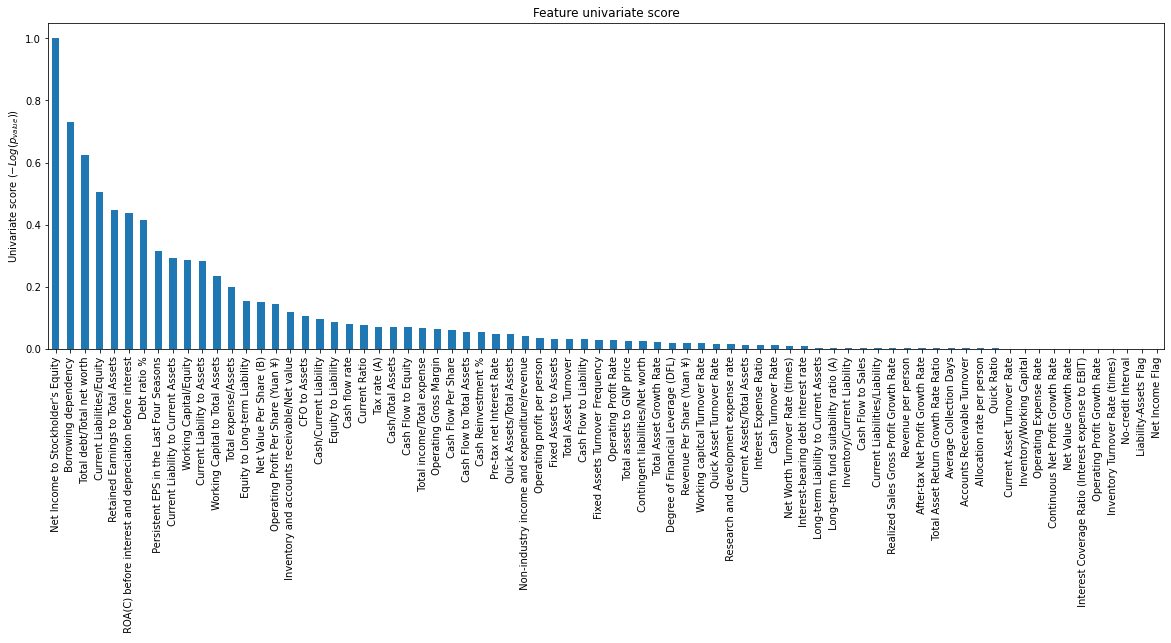

In [35]:
f_scores = FTestScores(x_train, y_train)

- The figure above helps us select the number of features to keep:

In [36]:
selector = SelectKBest(f_classif, k=len(f_scores.loc[f_scores > 0.4]))

# selecting the features:
selector.fit(x_train, y_train)

kept_columns = list(x_train.columns[selector.get_support()]) 

In [37]:
kept_columns

[' ROA(C) before interest and depreciation before interest',
 ' Total debt/Total net worth',
 ' Debt ratio %',
 ' Borrowing dependency',
 ' Current Liabilities/Equity',
 ' Retained Earnings to Total Assets',
 " Net Income to Stockholder's Equity"]

In [38]:
x_train = x_train[kept_columns]
x_val = x_val[kept_columns]
x_test = x_test[kept_columns]

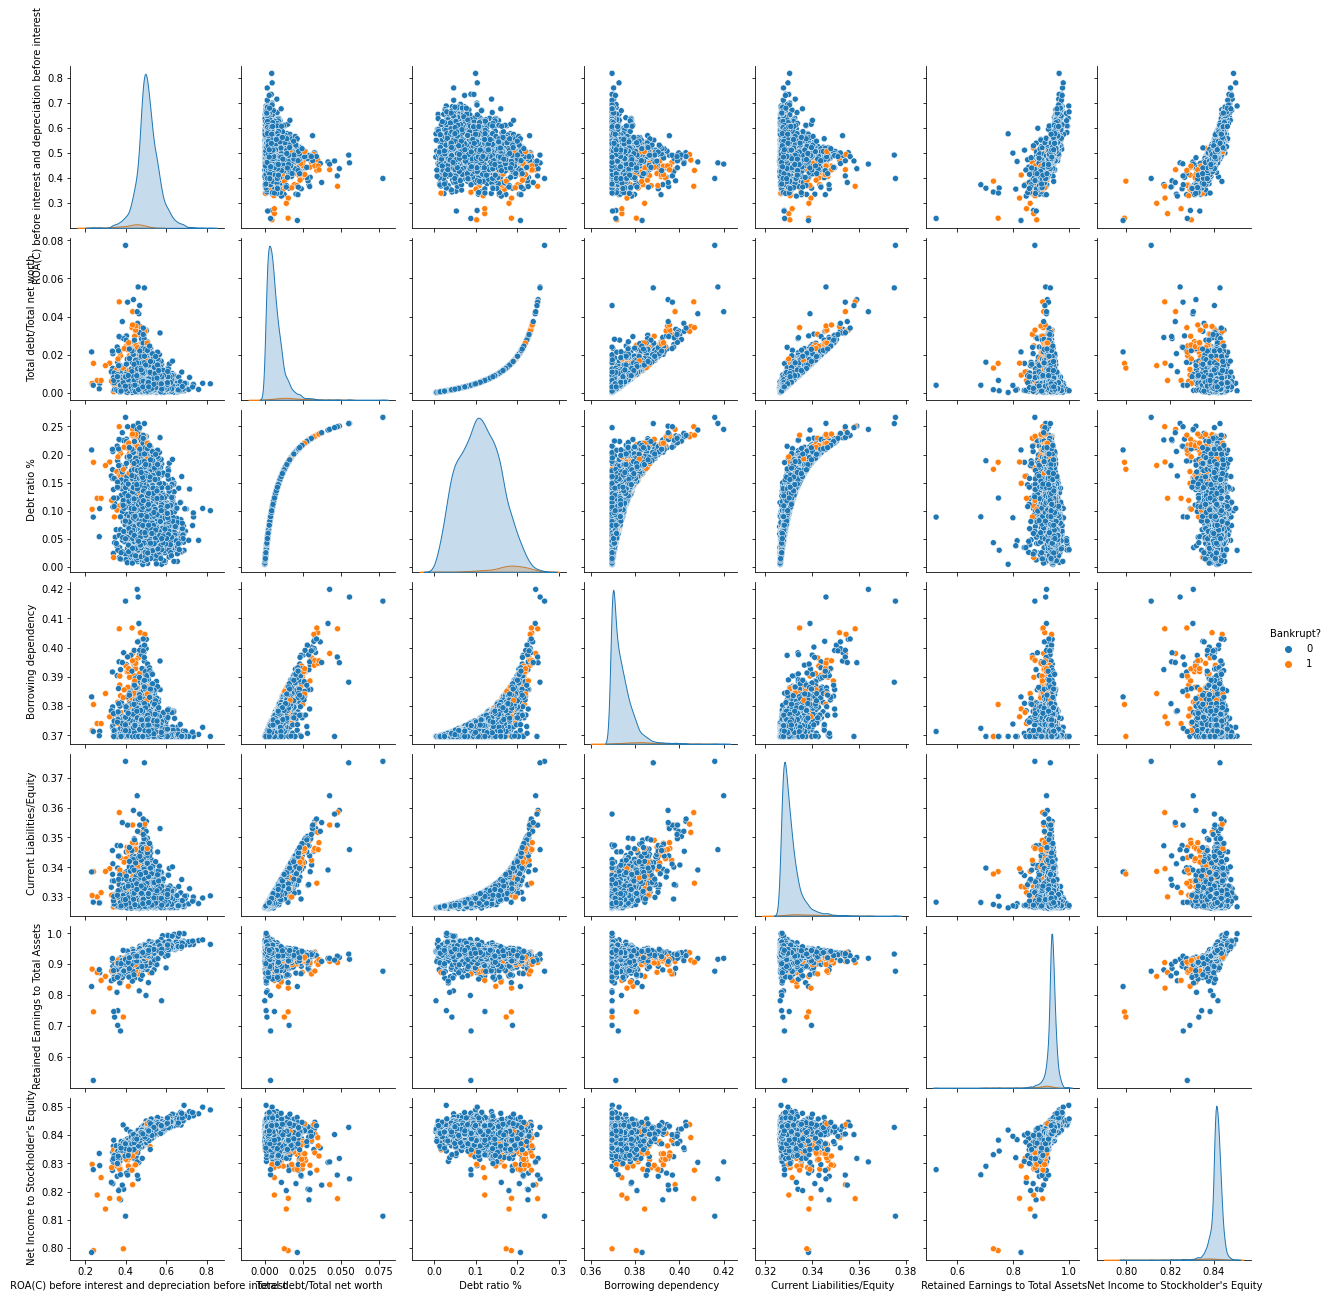

In [39]:
sns.pairplot(pd.concat([x_train, y_train], axis=1), hue="Bankrupt?")

__Data Normalization:__

In [40]:
# We use the standard scaler in order to normalize the data:

scaler = StandardScaler() 
x_train = scaler.fit_transform(x_train) 
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# Hyper parameters tuning:

__Using Keras tuner:__

In [41]:
ClassWeights = dict(enumerate(class_weight.compute_class_weight('balanced', 
                            classes=np.unique(y_train), y=y_train)))
ClassWeights

{0: 0.5148902821316614, 1: 17.289473684210527}

In [42]:
EarlyStop = EarlyStopping(monitor='val_f1', mode="max", patience=7, verbose=0) 

CallBacksList = [EarlyStop,]  

In [43]:
class MyHyperModel(kt.HyperModel):

    def build(self ,hp):

        hp_units_1 = hp.Choice("Layer 1", [16, 32]) 
        hp_units_2 = hp.Choice("Layer 2", [8, 16]) 
        hp_units_3 = hp.Choice("Layer 3", [4, 8])  
        hp_activation = hp.Choice("activation", ["relu", "tanh"]) 
        hp_kernel_initializer = hp.Choice("kernel_initializer", ["glorot_uniform", "glorot_normal"])
        hp_learning_rate = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log", default=1e-3)  
        hp_loss = hp.Choice("loss_type", ["BC", "FL"])
        hp_gamma = hp.Choice("Gamma", [0.0, 0.5, 1.0, 2.0])
        
        model = Sequential()
    
        model.add(layers.Dense(units = hp_units_1,
                        kernel_initializer = hp_kernel_initializer,
                        kernel_regularizer = tf.keras.regularizers.L2(0.1),
                        activation = hp_activation,
                        input_dim = x_train.shape[-1])) 
    
        # Tune whether to use dropout.
        if hp.Boolean("Dropout 1"):
            model.add(layers.Dropout(rate=0.5))
    
        model.add(layers.Dense(units = hp_units_2, 
                            kernel_initializer = hp_kernel_initializer,    
                            activation = hp_activation))
            
        if hp.Boolean("Dropout 2"):
            model.add(layers.Dropout(rate=0.5))
            
        model.add(layers.Dense(units = hp_units_3, 
                            kernel_initializer = hp_kernel_initializer,    
                            activation = hp_activation))
            
        if hp.Boolean("Dropout 3"):
            model.add(layers.Dropout(rate=0.5))
            
        model.add(layers.Dense(units=1, 
                            kernel_initializer = hp_kernel_initializer,
                            activation="sigmoid"))
            
        if hp_loss == "BC":
            with hp.conditional_scope("loss_type", ["BC"]):
                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
                        loss = tf.keras.losses.BinaryCrossentropy(),
                        metrics= ["accuracy", tf.keras.metrics.AUC(name="auc"), 
                                  tf.keras.metrics.Precision(name="precision"),
                                  tf.keras.metrics.Recall(name="recall"), f1])
        if hp_loss == "FL":
            with hp.conditional_scope("loss_type", ["FL"]):
                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
                        loss = tf.keras.losses.BinaryFocalCrossentropy(gamma = hp_gamma), 
                        metrics= ["accuracy", tf.keras.metrics.AUC(name="auc"), 
                                  tf.keras.metrics.Precision(name="precision"),
                                  tf.keras.metrics.Recall(name="recall"), f1])
    
        return model

    def fit(self, hp, model, x, y, validation_data=None, **kwargs):
        hp_batch_size = hp.Choice("batch_size", [16, 32, 64])
        
#         if hp.Boolean("normalize"):
#             x = layers.Normalization()(x)
        return model.fit(
            x,
            y,
            # Tune whether to shuffle the data in each epoch.
            shuffle=hp.Boolean("shuffle"),
            validation_data=validation_data,
            batch_size = hp_batch_size,
            class_weight = ClassWeights,
            **kwargs,
        )

In [44]:
tuner = kt.BayesianOptimization(
    hypermodel = MyHyperModel(),
    objective = kt.Objective("val_f1", direction="max"),
    seed = SEED,
    #max_epochs=100,
    #factor=3,
    #hyperband_iterations=1,
    max_trials = 50,
    overwrite=True,
    directory = 'Deep_learning_project',
    project_name = "Default_predictions"
)

In [45]:
tuner.search(x_train, y_train,
             validation_data = (x_val, y_val),
             epochs = 100,
             verbose = 2,
             initial_epoch = 0,
             callbacks = CallBacksList,
             use_multiprocessing = True,
            )

Trial 50 Complete [00h 00m 05s]
val_f1: 0.23034480214118958

Best val_f1 So Far: 0.28411343693733215
Total elapsed time: 00h 13m 45s
INFO:tensorflow:Oracle triggered exit


In [46]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal hyper parameters are:
The first layer: {best_hps.get("Layer 1")}. \n
The second layer: {best_hps.get("Layer 2")}. \n
The third layer: {best_hps.get("Layer 3")}. \n
The activation function: {best_hps.get("activation")}. \n
The kernel initializer: {best_hps.get("kernel_initializer")}. \n
The loss function: {best_hps.get("loss_type")}. \n  
The learning rate: {best_hps.get("learning_rate")}. \n
The batch size: {best_hps.get("batch_size")}. \n
Dropout 1: {best_hps.get("Dropout 1")}. \n
Dropout 2: {best_hps.get("Dropout 2")}. \n
Dropout 3: {best_hps.get("Dropout 3")}. \n
Shuffle: {best_hps.get("shuffle")}. \n
Gamma: {best_hps.get("Gamma")}. \n
""")

# Normalize the data: {best_hps.get("normalize")}. \n


The hyperparameter search is complete. The optimal hyper parameters are:
The first layer: 32. 

The second layer: 8. 

The third layer: 8. 

The activation function: tanh. 

The kernel initializer: glorot_normal. 

The loss function: FL. 
  
The learning rate: 0.004945789432958872. 

The batch size: 64. 

Dropout 1: True. 

Dropout 2: False. 

Dropout 3: False. 

Shuffle: True. 

Gamma: 2.0. 




***

__Building the model using the best hyperparameters:__

In [47]:
best_model_params = MyHyperModel().build(best_hps)

In [48]:
EarlyStop = EarlyStopping(monitor='val_f1', mode="max", patience=7, verbose=0) 

CallBacksList = [EarlyStop,]  

- We need to retrain the model:

In [49]:
history = best_model_params.fit(x_train,
            y_train,
            epochs = 500,
            # Tune whether to shuffle the data in each epoch.
            shuffle= best_hps.get("shuffle"),
            validation_data = (x_val, y_val),
            batch_size = best_hps.get("batch_size"),
            class_weight = ClassWeights,
            callbacks = CallBacksList,
            )

Epoch 1/500
52/52 [==============================] - 2s 18ms/step - loss: 0.6205 - accuracy: 0.7893 - auc: 0.9049 - precision: 0.1078 - recall: 0.8632 - f1: 0.1959 - val_loss: 0.2003 - val_accuracy: 0.9289 - val_auc: 0.9149 - val_precision: 0.2237 - val_recall: 0.5763 - val_f1: 0.2962
Epoch 2/500
52/52 [==============================] - 0s 4ms/step - loss: 0.1636 - accuracy: 0.8673 - auc: 0.9191 - precision: 0.1569 - recall: 0.8211 - f1: 0.2593 - val_loss: 0.1494 - val_accuracy: 0.8041 - val_auc: 0.9200 - val_precision: 0.1167 - val_recall: 0.8644 - val_f1: 0.1951
Epoch 3/500
52/52 [==============================] - 0s 4ms/step - loss: 0.1046 - accuracy: 0.8584 - auc: 0.9300 - precision: 0.1549 - recall: 0.8737 - f1: 0.2652 - val_loss: 0.0962 - val_accuracy: 0.8767 - val_auc: 0.9124 - val_precision: 0.1538 - val_recall: 0.7119 - val_f1: 0.2221
Epoch 4/500
52/52 [==============================] - 0s 4ms/step - loss: 0.1059 - accuracy: 0.8603 - auc: 0.9223 - precision: 0.1553 - recall: 0

In [50]:
best_model_params.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                256       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
 dense_6 (Dense)             (None, 8)                 72        
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________


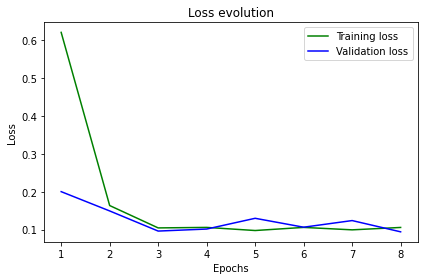

In [51]:
visualize_loss(history, "Loss evolution")

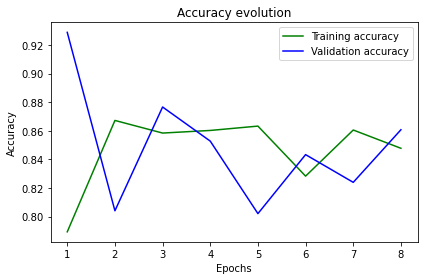

In [52]:
visualize_accuracy(history, "Accuracy evolution")

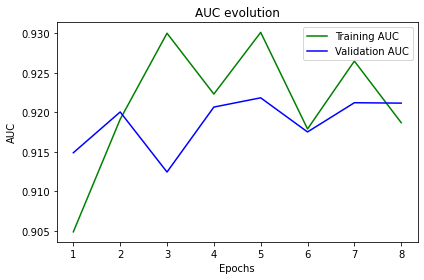

In [53]:
visualize_auc(history, "AUC evolution")

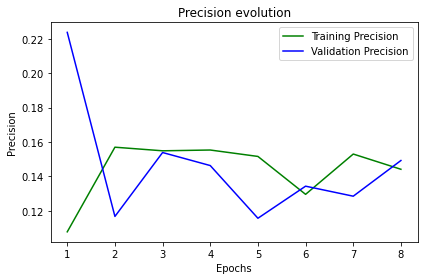

In [54]:
visualize_precision(history, "Precision evolution")

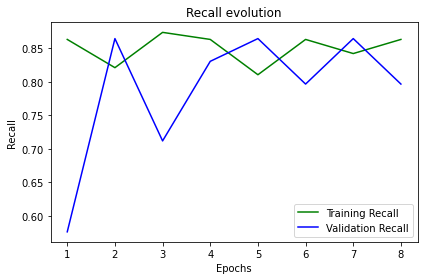

In [55]:
visualize_recall(history, "Recall evolution")

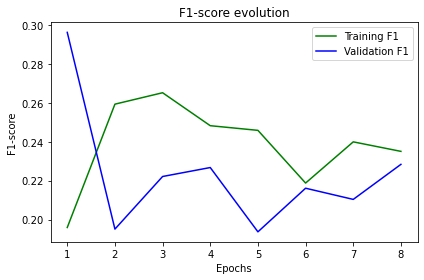

In [56]:
visualize_f1(history, "F1-score evolution")

In [57]:
best_model_params.save("best_model_params.h5")

In [58]:
y_pred_train = best_model_params.predict(x_train)
y_pred_test = best_model_params.predict(x_test)
y_pred_test_proba = best_model_params.predict(x_test)

In [59]:
y_pred_train = (y_pred_train>0.5).astype(int)
y_pred_test = (y_pred_test>0.5).astype(int)

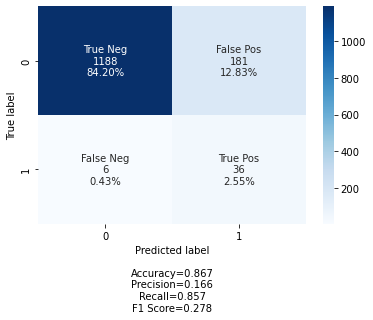

In [60]:
# Showing the confusion matrix

cm = metrics.confusion_matrix(y_test, y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')

In [61]:
# Showing the classification report:

TargetNames=["No Default", "Default"]
print(classification_report(y_test, y_pred_test, target_names = TargetNames))

              precision    recall  f1-score   support

  No Default       0.99      0.87      0.93      1369
     Default       0.17      0.86      0.28        42

    accuracy                           0.87      1411
   macro avg       0.58      0.86      0.60      1411
weighted avg       0.97      0.87      0.91      1411



In [62]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
ACCURACY,ACCURACY,0.881279,0.867470
PRECISION,PRECISION,0.180043,0.165899
RECALL,RECALL,0.877594,0.862465
F1 SCORE,F1 SCORE,0.616856,0.602515
AUC,AUC,0.877594,0.862465


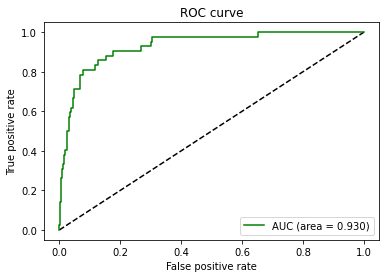

In [63]:
auc_plot(y_test, y_pred_test_proba)

***

__Building the model using the best hyperparameters and S.M.O.T.E:__

In [64]:
# S.M.O.T.E

sm = SMOTE(k_neighbors=5, random_state=SEED)
x_train_sm, y_train_sm = sm.fit_resample(x_train, y_train)

In [65]:
best_model_params_sm = MyHyperModel().build(best_hps)

In [66]:
EarlyStop = EarlyStopping(monitor='val_f1', mode="max", patience=7, verbose=0) 

CallBacksList = [EarlyStop,]  

In [67]:
history = best_model_params.fit(x_train_sm,
            y_train_sm,
            epochs = 500,
            # Tune whether to shuffle the data in each epoch.
            shuffle= best_hps.get("shuffle"),
            validation_data = (x_val, y_val),
            batch_size = best_hps.get("batch_size"),
            callbacks = CallBacksList,
            )

Epoch 1/500
100/100 [==============================] - 1s 4ms/step - loss: 0.0898 - accuracy: 0.8745 - auc: 0.9384 - precision: 0.8647 - recall: 0.8878 - f1: 0.8746 - val_loss: 0.1065 - val_accuracy: 0.8369 - val_auc: 0.9185 - val_precision: 0.1335 - val_recall: 0.8305 - val_f1: 0.2135
Epoch 2/500
100/100 [==============================] - 0s 4ms/step - loss: 0.0873 - accuracy: 0.8820 - auc: 0.9394 - precision: 0.8696 - recall: 0.8987 - f1: 0.8826 - val_loss: 0.0903 - val_accuracy: 0.8558 - val_auc: 0.9146 - val_precision: 0.1446 - val_recall: 0.7966 - val_f1: 0.2229
Epoch 3/500
100/100 [==============================] - 0s 4ms/step - loss: 0.0869 - accuracy: 0.8743 - auc: 0.9389 - precision: 0.8618 - recall: 0.8915 - f1: 0.8743 - val_loss: 0.0983 - val_accuracy: 0.8309 - val_auc: 0.9147 - val_precision: 0.1312 - val_recall: 0.8475 - val_f1: 0.2107
Epoch 4/500
100/100 [==============================] - 0s 4ms/step - loss: 0.0863 - accuracy: 0.8787 - auc: 0.9389 - precision: 0.8619 - re

In [68]:
best_model_params_sm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                256       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 8)                 264       
                                                                 
 dense_10 (Dense)            (None, 8)                 72        
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________


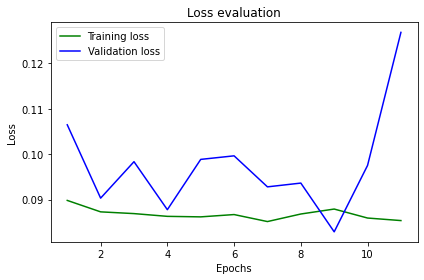

In [69]:
visualize_loss(history, "Loss evaluation")

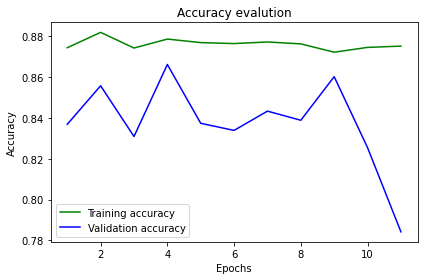

In [70]:
visualize_accuracy(history, "Accuracy evalution")

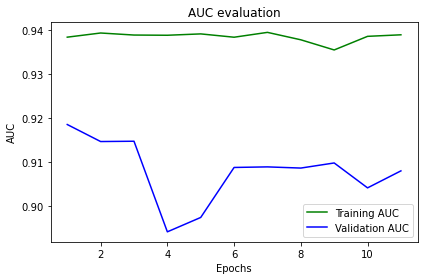

In [71]:
visualize_auc(history, "AUC evaluation")

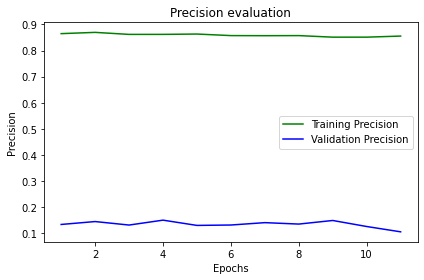

In [72]:
visualize_precision(history, "Precision evaluation")

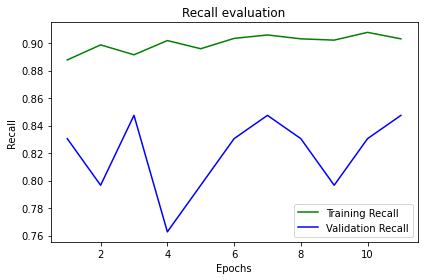

In [73]:
visualize_recall(history, "Recall evaluation")

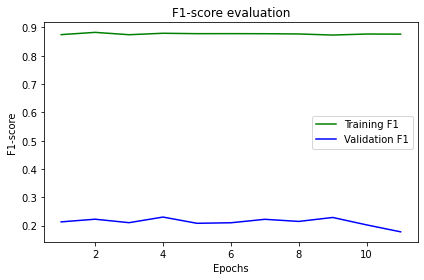

In [74]:
visualize_f1(history, "F1-score evaluation")

In [75]:
best_model_params_sm.save("best_model_params_sm.h5")

In [76]:
y_pred_train = best_model_params_sm.predict(x_train)
y_pred_test = best_model_params_sm.predict(x_test)
y_pred_test_proba = best_model_params_sm.predict(x_test)

In [77]:
y_pred_train = (y_pred_train>0.5).astype(int)
y_pred_test = (y_pred_test>0.5).astype(int)

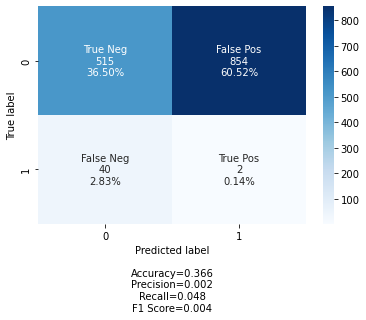

In [78]:
# Showing the confusion matrix

cm = metrics.confusion_matrix(y_test, y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')

In [79]:
# Showing the classification report:

TargetNames=["No Default", "Default"]
print(classification_report(y_test, y_pred_test, target_names = TargetNames))

              precision    recall  f1-score   support

  No Default       0.93      0.38      0.54      1369
     Default       0.00      0.05      0.00        42

    accuracy                           0.37      1411
   macro avg       0.47      0.21      0.27      1411
weighted avg       0.90      0.37      0.52      1411



In [80]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
ACCURACY,ACCURACY,0.347336,0.366407
PRECISION,PRECISION,0.001945,0.002336
RECALL,RECALL,0.199266,0.211903
F1 SCORE,F1 SCORE,0.259215,0.269899
AUC,AUC,0.199266,0.211903


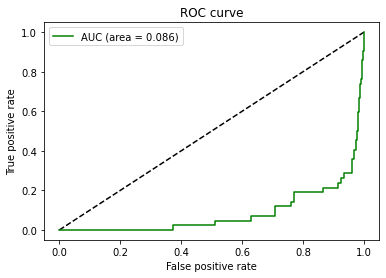

In [81]:
auc_plot(y_test, y_pred_test_proba)

- As we can see using S.M.O.T.E is not a good idea.

***

__Getting the best tuned model with the best hyper parameters:__

In [82]:
best_model = tuner.get_best_models(1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                256       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________


In [83]:
best_model.save("best_model.h5")

In [84]:
y_pred_train = best_model.predict(x_train)
y_pred_test = best_model.predict(x_test)
y_pred_test_proba = best_model.predict(x_test)

In [85]:
y_pred_train = (y_pred_train>0.5).astype(int)
y_pred_test = (y_pred_test>0.5).astype(int)

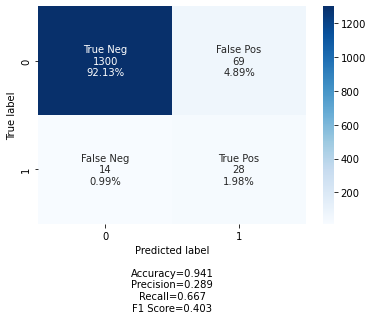

In [86]:
# Showing the confusion matrix

cm = metrics.confusion_matrix(y_test, y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')

In [87]:
# Showing the classification report:

TargetNames=["No Default", "Default"]
print(classification_report(y_test, y_pred_test, target_names = TargetNames))

              precision    recall  f1-score   support

  No Default       0.99      0.95      0.97      1369
     Default       0.29      0.67      0.40        42

    accuracy                           0.94      1411
   macro avg       0.64      0.81      0.69      1411
weighted avg       0.97      0.94      0.95      1411



In [88]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
ACCURACY,ACCURACY,0.941248,0.941176
PRECISION,PRECISION,0.271028,0.288660
RECALL,RECALL,0.780812,0.808132
F1 SCORE,F1 SCORE,0.672289,0.685971
AUC,AUC,0.780812,0.808132


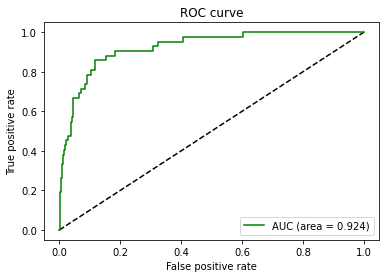

In [89]:
auc_plot(y_test, y_pred_test_proba)

***

In [90]:
t2 = time.perf_counter()
print('Time taken to run in minutes:',(t2-t1)/60.0)

Time taken to run in minutes: 14.7195257
